In [ ]:
!pip install emoji

In [ ]:
#@title Check GPU and Location
!curl ipinfo.io

import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)
print(device_name)
if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
    Unfortunately this instance does not have a T4, P4 or P100 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100. Resetting the instance.
If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!')

  !nvidia-smi

{
  "ip": "34.135.126.234",
  "hostname": "234.126.135.34.bc.googleusercontent.com",
  "city": "Council Bluffs",
  "region": "Iowa",
  "country": "US",
  "loc": "41.2619,-95.8608",
  "org": "AS15169 Google LLC",
  "postal": "51502",
  "timezone": "America/Chicago",
  "readme": "https://ipinfo.io/missingauth"
}b'Tesla K80'


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 2))



Exception: ignored

In [ ]:
import os
import json
import torch
import emoji
import re
import operator
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def word_process(word, use_emoji):  # emoji 처리
    if use_emoji:
        return emoji.demojize(word).replace(':', ' ') + ' '
    else:
        return word.encode('ascii', 'ignore').decode('ascii') + ' '

In [ ]:
def remove_space(txt):
    txt = txt.replace('  ', ' ')
    if '  ' in txt:
        remove_space(txt)
    else:
        return txt

In [ ]:
class PreprocessDataset:
    def __init__(self):
        # 개별 post
        self.img = []
        self.text = []
        self.hashtags = []

        # vocab 정보들
        self.hashtag_vocab = {}  # {"hashtag1":0, "hashtag2":1, ...}
        self.hashtag_freq = {}  # {"hashtag" : count, ...}
        self.word_vocab = {"<PAD>": 0}  # {"word1":0, "word2":1, ...}
        self.word_freq = {"<PAD>": 0}  # {"word" : count}
        self.hashtag_vocab_size = 0
        self.word_vocab_size = 1

    def add_data(self, img, text, hashtags):
        self.img.append(img)
        self.text.append(text)
        self.hashtags.append(hashtags)
        # print(text)
        for hashtag in hashtags:
            if hashtag not in self.hashtag_freq.keys():
                self.hashtag_freq[hashtag] = 1
                self.hashtag_vocab[hashtag] = self.hashtag_vocab_size
                self.hashtag_vocab_size += 1
            else:
                self.hashtag_freq[hashtag] += 1

        for word in text.split():
            if word not in self.word_freq.keys():
                if word[-1] != '분':
                    self.word_freq[word] = 1
                    self.word_vocab[word] = self.word_vocab_size
                    self.word_vocab_size += 1
                    # print("성공"+word)
            else:
                self.word_freq[word] += 1


    def remove_low_freq(self):
        '''
        해시태그는 5645개 중 상위 2000개, 단어는 3147개 중 상위 3000개만 남김
        '''
        print("vocab_size:", self.word_vocab_size)
        print("hashtag_size:", self.hashtag_vocab_size)
        print("hashtags:", self.hashtag_freq)
        print("words:", self.word_freq)
        sorted_hashtag = sorted(self.hashtag_freq.values(), reverse=True)
        sorted_vocab = sorted(self.word_freq.values(), reverse=True)
        plt.plot(sorted_hashtag)
        plt.show()
        plt.plot(sorted_vocab)
        plt.show()

        new_hashtag_vocab = {}  # {"hashtag1":0, "hashtag2":1, ...}
        sorted_tags = sorted(self.hashtag_freq.items(), key=operator.itemgetter(1), reverse=True)
        for i, each_tuple in enumerate(sorted_tags[:1000]):
            new_hashtag_vocab[each_tuple[0]] = i

        new_word_vocab = {}  # {"word1":0, "word2":1, ...}
        sorted_words = sorted(self.word_freq.items(), key=operator.itemgetter(1), reverse=True)
        for i, each_tuple in enumerate(sorted_words[:3000]):
            new_word_vocab[each_tuple[0]] = i

        new_img = []
        new_text = []
        new_hashtags = []
        new_hashtags_onehot = []
        for i in tqdm(range(len(self.text))):
            new_tags = []
            new_tags_onehot = [0 for q in range(len(new_hashtag_vocab))]
            for tag in self.hashtags[i]:
                if tag in new_hashtag_vocab.keys():
                    new_tags.append(new_hashtag_vocab[tag])
                    new_tags_onehot[new_hashtag_vocab[tag]] = 1
            new_words = []
            for word in self.text[i].split():
                if word in new_word_vocab.keys():
                    new_words.append(new_word_vocab[word])
            if new_words and new_tags:
                for each_tag in new_tags:
                    new_img.append(self.img[i])
                    new_text.append(new_words)
                    new_hashtags.append(each_tag)
                    new_hashtags_onehot.append(new_tags_onehot)

        self.img = new_img
        self.text = new_text
        self.hashtags = new_hashtags
        self.hashtag_vocab = new_hashtag_vocab
        self.hashtag_vocab_size = len(new_hashtag_vocab)
        self.word_vocab = new_word_vocab
        self.word_vocab_size = len(new_word_vocab)
        self.new_hashtags_onehot = new_hashtags_onehot

In [ ]:
def create_raw_data(path, use_emoji):
    hashtags = os.listdir(path)
    hashdataset = PreprocessDataset()
    img_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    backbone = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
    backbone.eval()
    if torch.cuda.is_available():
        backbone.to('cuda')
    else:
        backbone.to('cpu')
    for tag in tqdm(hashtags, total=len(hashtags)):
#         output_path = os.path.join(path, tag, 'des/output.json')
        output_path = os.path.join(path,tag,tag+'.csv')
        df = pd.read_csv(output_path,encoding='utf-8-sig')
    #성공 --
#        with open(output_path, 'rb') as f:
#            output_file = json.load(f)
        for i in range(len(df)):
            post_text = ''
            post_hashtags = ast.literal_eval(df.iloc[i]['hashtags'])
            #print(post_hashtags)
            description = df.iloc[i]['contents'].split()
            img_path = os.path.join(path, tag , str(i)+'-0.jpg')
            try:
                input_img = Image.open(img_path)
                input_img = input_img.resize((640,640))
            except:
                continue
            if torch.cuda.is_available():
                img_tensor = img_preprocess(input_img).to("cuda")  # [3,224,224]
            else:
                img_tensor = img_preprocess(input_img)

            # image grid 생성
            crop_idx = [q * 32 for q in range(8)]
            grid_tensor = []
            for i in range(len(crop_idx) - 1):
                for j in range(len(crop_idx) - 1):
                    grid_tensor.append(img_tensor[:, crop_idx[i]:crop_idx[i + 1], crop_idx[j]:crop_idx[j + 1]])

            grid_tensor = torch.stack(grid_tensor)  # [7, 3, 32, 32]
            with torch.no_grad():
                vgg_output = backbone(grid_tensor)  # [7, 1000]
            
            for word in description:
                if word[0] == '@':
                    continue
                elif word[0] == '#':
                    continue
                else:
                    post_text += word.lower()


            pattern = '(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+'  # url 제거
            post_text = re.sub(pattern=pattern, repl=' ', string=post_text)
            pattern = '[^\w\s]'  # 특수기호 제거
            post_text = re.sub(pattern=pattern, repl=' ', string=post_text)
            post_text = remove_space(post_text)  # 공백 제거
            if not post_text or post_text == ' ' or not post_hashtags: continue
            if post_text[0] == ' ': post_text = post_text[1:]
            hashdataset.add_data(vgg_output, post_text, post_hashtags)

    hashdataset.remove_low_freq()
    print(hashdataset.text)
    print(hashdataset.hashtags)
    for q in range(20):
        print(hashdataset.text[q])
        print(hashdataset.hashtags[q])
        print("-------------------------------------------------")
    print(len(hashdataset.text), len(hashdataset.img), len(hashdataset.hashtags))
    print(hashdataset.word_vocab_size, hashdataset.hashtag_vocab_size)

    with open("raw_data.pkl", "wb") as f:
        pickle.dump([hashdataset.img, hashdataset.text, hashdataset.hashtags,
                     hashdataset.hashtag_vocab, hashdataset.word_vocab,
                     hashdataset.new_hashtags_onehot], f)


In [ ]:
print(torch.__version__)

1.10.0+cu111


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 44/44 [16:41<00:00, 22.75s/it]


vocab_size: 17717
hashtag_size: 29634
hashtags: {'sexed': 8, 'sexylingerie': 7, 'sexydresses': 2, 'sexy': 42, 'football': 12, 'footnail': 1, 'love': 1974, 'lovequotes': 57, 'ukraine': 10, 'ukraina': 1, 'putin': 1, 'longhair': 24, 'nails': 59, 'genshinimpact': 1, 'gym': 126, 'gymmotivation': 33, 'new': 61, 'dio': 2, 'hiphop': 33, 'rap': 24, 'music': 430, 'rapper': 7, 'trap': 6, 'beats': 6, 'newmusic': 11, 'hiphopmusic': 4, 'artist': 302, 'producer': 10, 'dance': 52, 'rnb': 2, 'dj': 10, 'rapmusic': 4, 'art': 1107, 'soundcloud': 4, 'hiphopculture': 4, 'explorepage': 243, 'spotify': 3, 'freestyle': 4, 'rappers': 3, 'youtube': 29, 'musicproducer': 7, 'instagood': 1842, 'follow': 1031, 'bhfyp': 1103, 'beatmaker': 1, 'musician': 12, 'boys': 30, 'girls': 115, 'boy': 55, 'like': 813, 'instagram': 1492, 'fashion': 1214, 'cute': 832, 'gay': 42, 'men': 40, 'photography': 1718, 'model': 728, 'photooftheday': 1525, 'style': 984, 'man': 26, 'girl': 521, 'likeforlikes': 632, 'me': 727, 'happy': 925, '

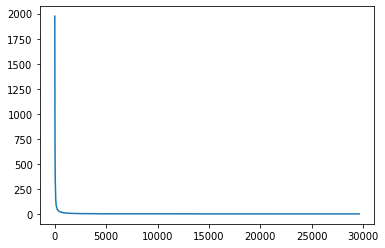

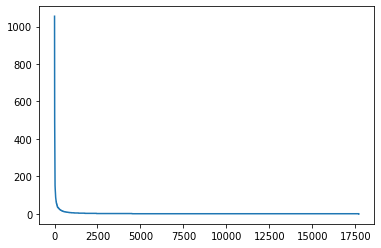

100%|██████████| 6095/6095 [00:00<00:00, 12609.00it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
create_raw_data("/content/drive/MyDrive/인스타/hashtag",True)